# ADS505 Final Project (Team 2)

## Required Packages

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import warnings
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix


warnings.filterwarnings("ignore")

## Descriptive Analytics

In [2]:
# load the dataset
df = pd.read_csv('./Big_Black_Money_Dataset_V2.csv')
df.head()

,Unnamed: 0,Transaction ID,Country,Amount (USD),Transaction Type,Date of Transaction,Person Involved,Industry,Destination Country,Reported by Authority,Source of Money,Money Laundering Risk Score,Shell Companies Involved,Financial Institution,Tax Haven Country
0,0,TX0000000001,Brazil,70642,Offshore Transfer,1/1/13 0:00,Person_1101,Construction,USA,True,Legal,4.943966,1,Bank_40,Singapore
1,1,TX0000000002,China,308761,Stocks Transfer,1/1/13 1:00,Person_7484,Luxury Goods,South Africa,False,Legal,5.217588,0,Bank_461,Bahamas
2,2,TX0000000003,UK,319746,Stocks Transfer,1/1/13 2:00,Person_3655,Construction,Switzerland,True,Illegal,6.904060,3,Bank_387,Switzerland
3,3,TX0000000004,UAE,55036,Cash Withdrawal,1/1/13 3:00,Person_3226,Oil & Gas,Russia,False,Legal,6.102097,2,Bank_353,Panama
4,4,TX0000000005,South Africa,50838,Cryptocurrency,1/1/13 4:00,Person_7975,Real Estate,USA,True,Legal,3.784610,9,Bank_57,Luxembourg


In [3]:
# Data Structure
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 15 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Unnamed: 0                   10000 non-null  int64  
 1   Transaction ID               10000 non-null  object 
 2   Country                      10000 non-null  object 
 3   Amount (USD)                 10000 non-null  int64  
 4   Transaction Type             10000 non-null  object 
 5   Date of Transaction          10000 non-null  object 
 6   Person Involved              10000 non-null  object 
 7   Industry                     10000 non-null  object 
 8   Destination Country          10000 non-null  object 
 9   Reported by Authority        10000 non-null  bool   
 10  Source of Money              10000 non-null  object 
 11  Money Laundering Risk Score  10000 non-null  float64
 12  Shell Companies Involved     10000 non-null  int64  
 13  Financial Institu

In [33]:
# Convert 'Date of Transaction' to datetime
df['Date of Transaction'] = pd.to_datetime(df['Date of Transaction'])

# Convert datetime to seconds since epoch
df['Transaction_Seconds'] = (df['Date of Transaction'] - pd.Timestamp("1970-01-01")) // pd.Timedelta('1s')

## Univariate Analysis

In [5]:
# Summary statistics
print(df.describe())
print()

# Unique Value Counts
print('Unique Column Values Count')
print('-------------------------------')
print(df.nunique())

        Unnamed: 0  Amount (USD)  Date of Transaction  \
count  10000.00000  1.000000e+04                10000   
mean    4999.50000  1.762247e+05  2013-07-28 07:30:00   
min        0.00000  1.000000e+00  2013-01-01 00:00:00   
25%     2499.75000  5.261950e+04  2013-04-15 03:45:00   
50%     4999.50000  1.062550e+05  2013-07-28 07:30:00   
75%     7499.25000  2.120970e+05  2013-11-09 11:15:00   
max     9999.00000  5.250000e+06  2014-02-21 15:00:00   
std     2886.89568  2.258833e+05                  NaN   

       Money Laundering Risk Score  Shell Companies Involved  \
count                 10000.000000              10000.000000   
mean                      5.198323                  4.469400   
min                       1.509904                  0.000000   
25%                       4.407336                  2.000000   
50%                       5.121634                  4.000000   
75%                       5.917360                  7.000000   
max                       9.968095    

## Multivariate Analysis

### Correlation Heatmap

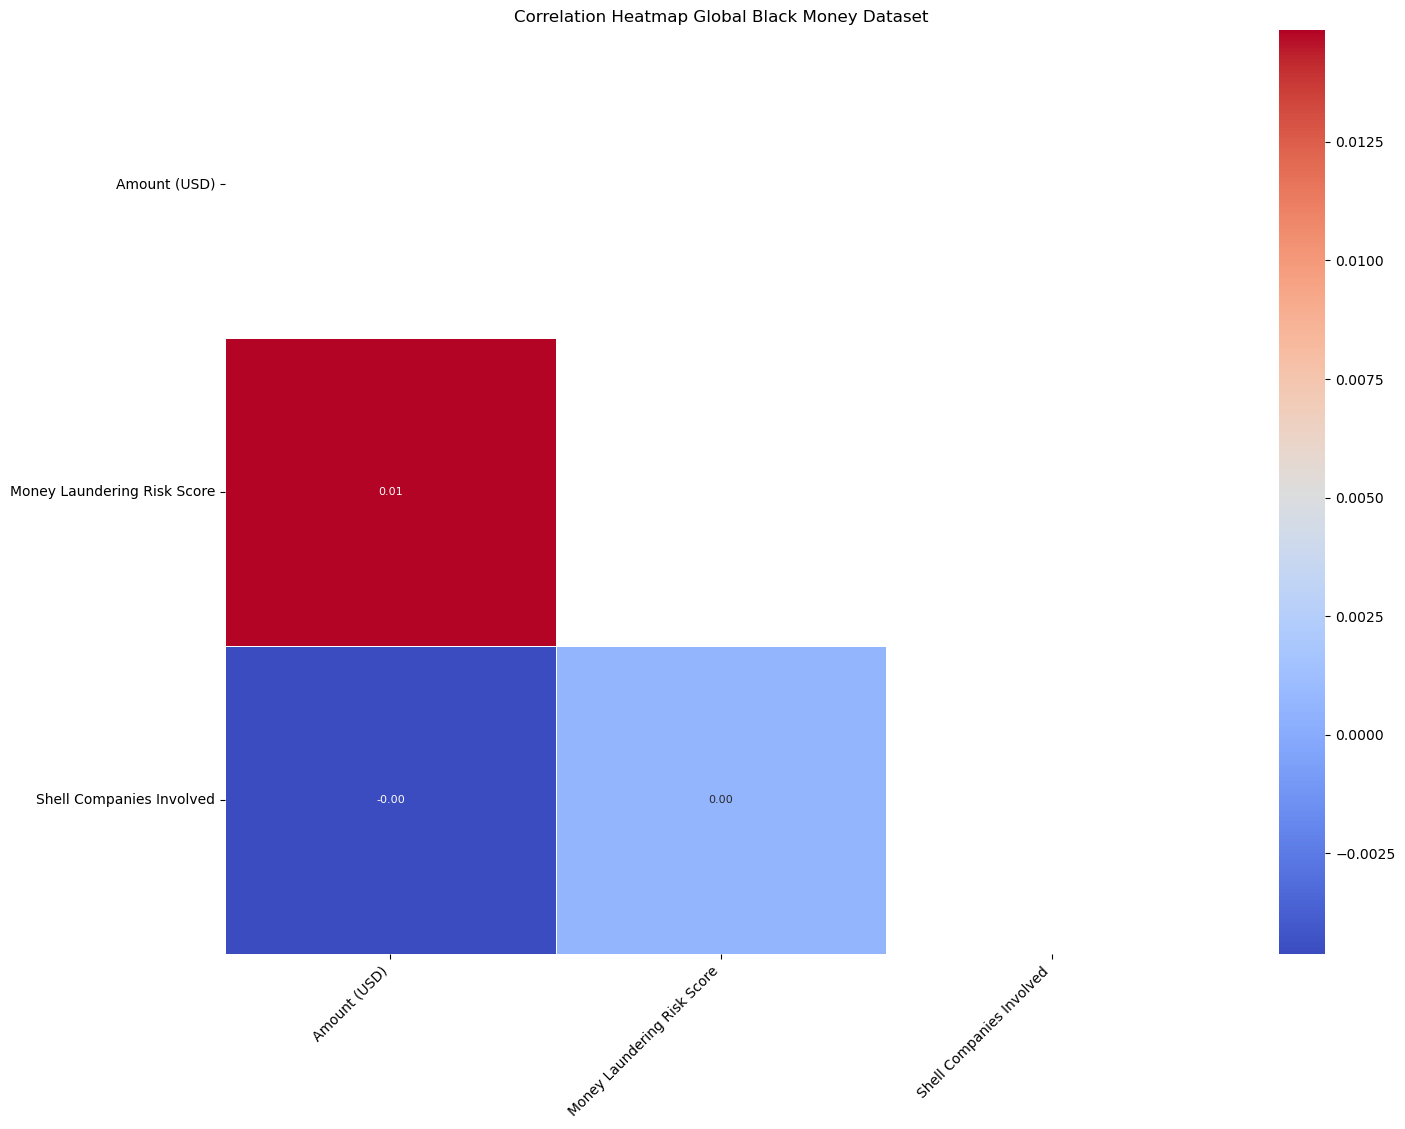

In [38]:
# Define Numeric Variables
numeric_predictors = ['Amount (USD)', 'Money Laundering Risk Score',  'Shell Companies Involved']

# Init Correlation Matrix
corr_matrix = df[numeric_predictors].corr()

# Create a heatmap
corr_matrix = corr_matrix

# Create a mask for the upper triangle
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

plt.figure(figsize=(16, 12))
heatmap = sns.heatmap(corr_matrix, mask=mask, annot=True, fmt=".2f", cmap='coolwarm', linewidths=0.5, annot_kws={"size": 8})

# Rotate the x and y labels for better readability
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.title('Correlation Heatmap Global Black Money Dataset')

# Show the heatmap
plt.show()

### Distribution of illegal vs legal transactions

Source of Money
False    8982
True     1017
Name: count, dtype: int64


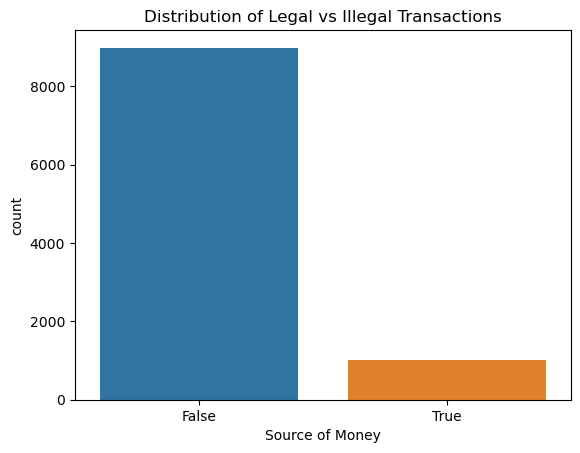

In [37]:
# Distribution of illegal vs legal transactions
print(df['Source of Money'].value_counts())

sns.countplot(x='Source of Money', data=df)
plt.title('Distribution of Legal vs Illegal Transactions')
plt.show()

### Distribution of illegal transactions by Industry

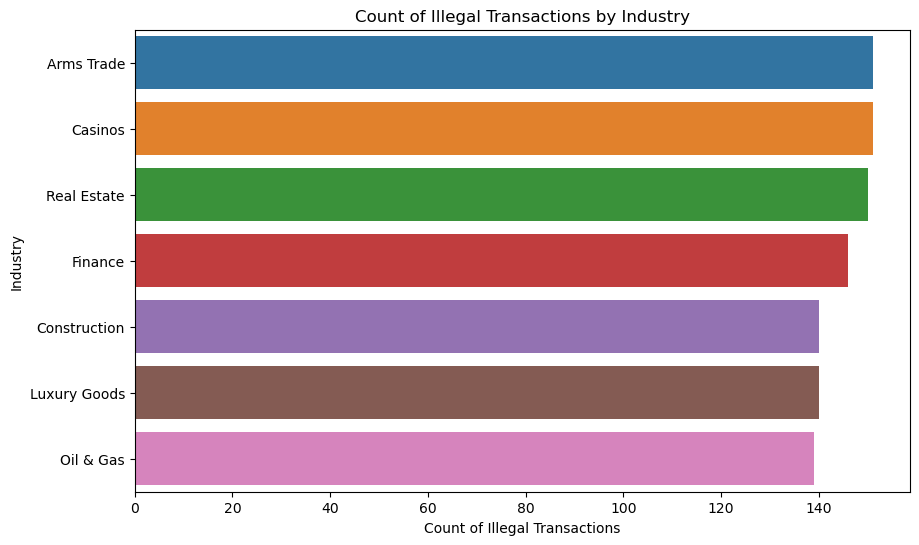

In [39]:
# Map True/False to 'Illegal'/'Legal' in the 'Source of Money' column
df['Source of Money'] = df['Source of Money'].map({True: 'Illegal', False: 'Legal'})

# Filter the dataset for illegal transactions
illegal_transactions = df[df['Source of Money'] == 'Illegal']

plt.figure(figsize=(10, 6))
sns.countplot(y='Industry', data=illegal_transactions, order=illegal_transactions['Industry'].value_counts().index)
plt.title('Count of Illegal Transactions by Industry')
plt.xlabel('Count of Illegal Transactions')
plt.ylabel('Industry')
plt.show()

### Distribution of overall transaction amount

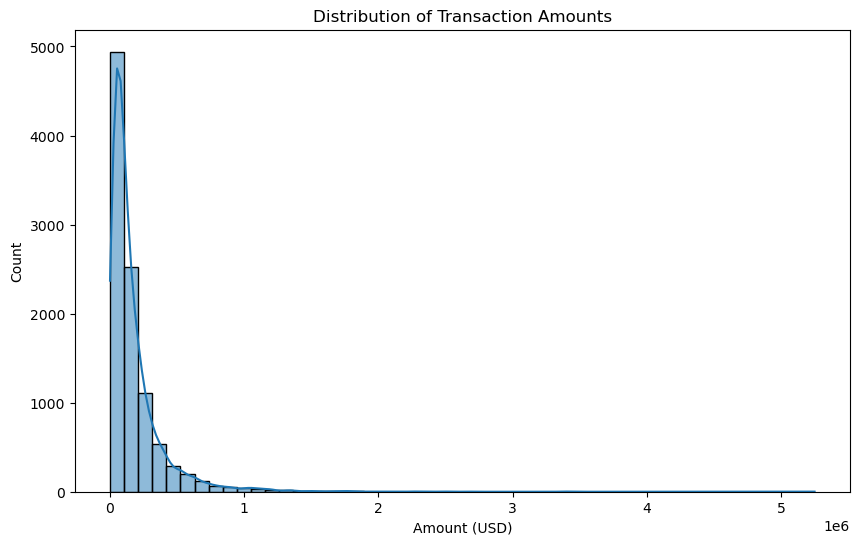

In [8]:
# Distribution of the overall transaction amounts
plt.figure(figsize=(10, 6))
sns.histplot(df['Amount (USD)'], bins=50, kde=True)
plt.title('Distribution of Transaction Amounts')
plt.show()

### Transaction amount by source

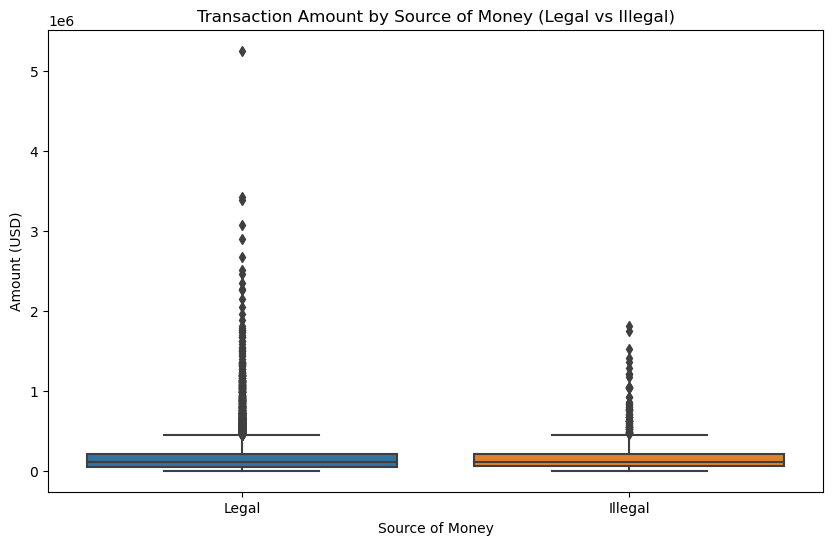

In [9]:
# Boxplot to compare Amount by Source of Money
plt.figure(figsize=(10, 6))
sns.boxplot(x='Source of Money', y='Amount (USD)', data=df)
plt.title('Transaction Amount by Source of Money (Legal vs Illegal)')
plt.show()

### Distribution of money laundering risk score

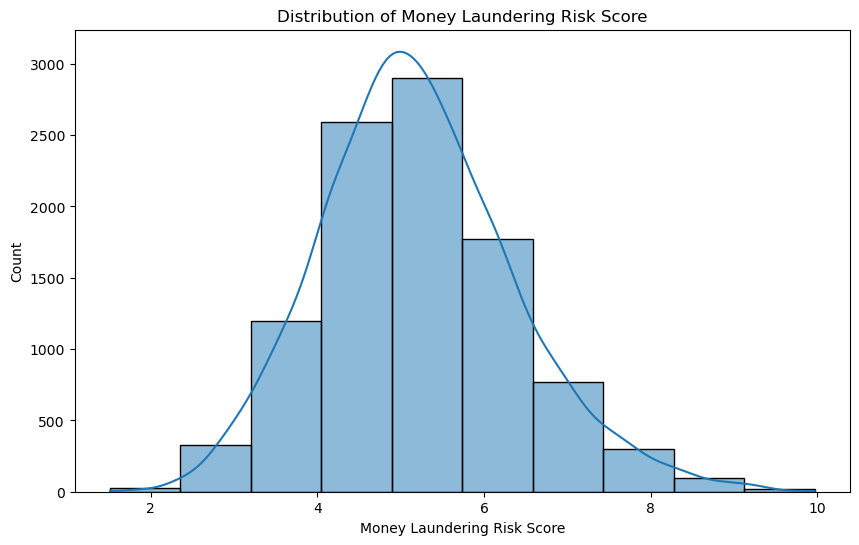

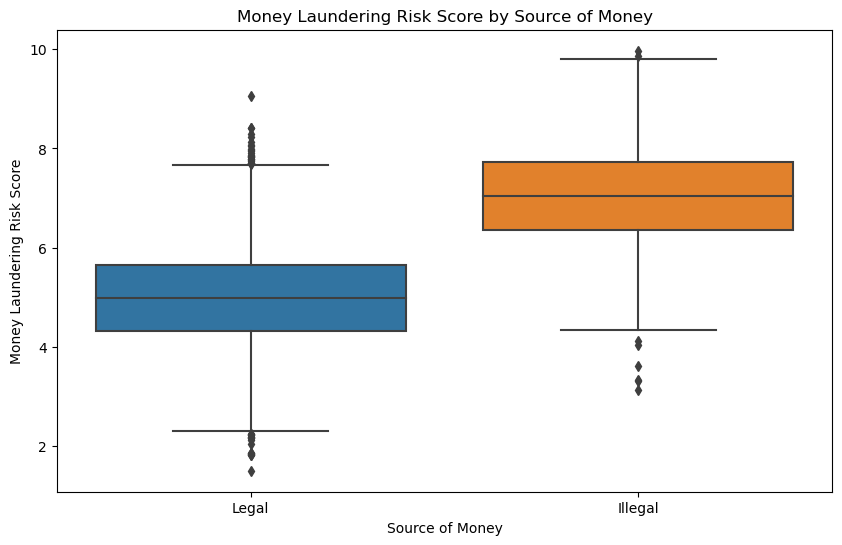

In [10]:
# Money Laundering Risk Score
plt.figure(figsize=(10, 6))
sns.histplot(df['Money Laundering Risk Score'], bins=10, kde=True)
plt.title('Distribution of Money Laundering Risk Score')
plt.show()

# Boxplot to compare Risk Score by Source of Money
plt.figure(figsize=(10, 6))
sns.boxplot(x='Source of Money', y='Money Laundering Risk Score', data=df)
plt.title('Money Laundering Risk Score by Source of Money')
plt.show()

### Distribution of Illegal Transactions by Country

Country
Brazil          171
UAE             154
UK              144
Singapore        93
India            87
China            83
Russia           79
USA              75
Switzerland      68
South Africa     63
Name: count, dtype: int64


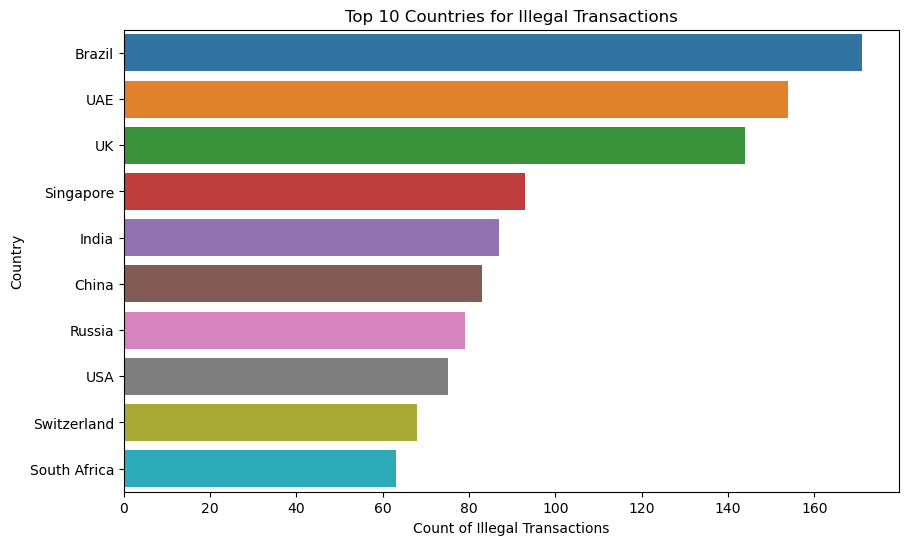

In [11]:
# Top countries for illegal transactions
illegal_countries = df[df['Source of Money'] == 'Illegal']['Country'].value_counts().head(10)
print(illegal_countries)

# top 10 countries
plt.figure(figsize=(10, 6))
sns.barplot(x=illegal_countries.values, y=illegal_countries.index)
plt.title('Top 10 Countries for Illegal Transactions')
plt.xlabel('Count of Illegal Transactions')
plt.show()

In [13]:
print(df.dtypes)

# Selecting categorical variables
categorical_vars = df.select_dtypes(include=['object', 'category']).columns.tolist()
print('Categorical Variables:', categorical_vars)

# Display unique values for categorical columns
for col in categorical_vars:
    print(f"{col}: {df[col].unique()}")

Unnamed: 0                              int64
Transaction ID                         object
Country                                object
Amount (USD)                            int64
Transaction Type                       object
Date of Transaction            datetime64[ns]
Person Involved                         int64
Industry                               object
Destination Country                    object
Reported by Authority                    bool
Source of Money                        object
Money Laundering Risk Score           float64
Shell Companies Involved                int64
Financial Institution                  object
Tax Haven Country                      object
Transaction_Seconds                     int64
Person Involved Binned               category
dtype: object
Categorical Variables: ['Transaction ID', 'Country', 'Transaction Type', 'Industry', 'Destination Country', 'Source of Money', 'Financial Institution', 'Tax Haven Country', 'Person Involved Binned']
Trans

## Data Preprocessing

In [40]:
# Convert 'Source of Money' to boolean (True for 'Illegal', False for 'Legal')
df['Source of Money'] = df['Source of Money'].map({'Illegal': True, 'Legal': False})

In [15]:
# Create dummy variables for categorical variables
df_dummies = pd.get_dummies(df, columns=categorical_vars, drop_first=True)

# new DataFrame with dummy variables
print(df_dummies.head())

   Unnamed: 0  Amount (USD) Date of Transaction  Person Involved  \
0           0         70642 2013-01-01 00:00:00             1101   
1           1        308761 2013-01-01 01:00:00             7484   
2           2        319746 2013-01-01 02:00:00             3655   
3           3         55036 2013-01-01 03:00:00             3226   
4           4         50838 2013-01-01 04:00:00             7975   

   Reported by Authority  Money Laundering Risk Score  \
0                   True                     4.943966   
1                  False                     5.217588   
2                   True                     6.904060   
3                  False                     6.102097   
4                   True                     3.784610   

   Shell Companies Involved  Transaction_Seconds  Transaction ID_TX0000000002  \
0                         1           1356998400                        False   
1                         0           1357002000                         True   
2    

In [16]:
# Check for missing data
print(df.isnull().sum())

# Drop rows with missing values if needed
df.dropna(inplace=True)

Unnamed: 0                     0
Transaction ID                 0
Country                        0
Amount (USD)                   0
Transaction Type               0
Date of Transaction            0
Person Involved                0
Industry                       0
Destination Country            0
Reported by Authority          0
Source of Money                0
Money Laundering Risk Score    0
Shell Companies Involved       0
Financial Institution          0
Tax Haven Country              0
Transaction_Seconds            0
Person Involved Binned         1
dtype: int64


In [17]:
# Create df_clean by dropping rows with missing 'Person Involved'
df_clean = df.dropna(subset=['Person Involved'])

# Ensure that 'Person Involved' is treated as an integer
df_clean['Person Involved'] = df_clean['Person Involved'].astype(int)

In [18]:
# Use df_clean for features and ensure to select only numeric columns
X = df_dummies.loc[df_clean.index]  # Select only rows in df_clean

# Drop any non-numeric columns 
X_numeric = X.select_dtypes(include=[np.number])  # Keep only numeric columns

In [19]:
# Split the data
X = df_dummies.loc[df_clean.index]  # Use df_clean for consistent rows
y = df_clean['Source of Money']  # Target variable

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)

# Keep only numeric columns
X_numeric = X.select_dtypes(include=[np.number])

# Scale the numeric features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_numeric.loc[X_train.index])
X_test_scaled = scaler.transform(X_numeric.loc[X_test.index])

## Model Investigations

### Model 1: Logistic Regression

In [20]:
# Initialize the logistic regression model
log_reg = LogisticRegression(max_iter=2000, solver='liblinear')

# Fit model to scaled training data
log_reg.fit(X_train_scaled, y_train)


LogisticRegression(max_iter=2000, solver='liblinear')

In [21]:
# Make predictions on test set
y_pred = log_reg.predict(X_test_scaled)

# Evaluate model
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print('Model Performance on Test Set:')
print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')

Model Performance on Test Set:
Accuracy: 0.9285
Precision: 0.7632
Recall: 0.4286
F1 Score: 0.5489


In [22]:
# Define hyperparameter grid to search
param_grid = {
    'C': [0.01, 0.1, 1, 10],
    'solver': ['liblinear', 'saga'],  # Solvers for regularization
    'penalty': ['l1', 'l2']           # L1 or L2 regularization
}

# Initialize Grid Search with cross-validation
grid_search = GridSearchCV(LogisticRegression(max_iter=1000), param_grid, cv=5, scoring='f1')

# Fit Grid Search to training data
grid_search.fit(X_train_scaled, y_train)

# Best hyperparameters
print('Best hyperparameters:', grid_search.best_params_)

# Re-train model with best parameters
best_log_reg = grid_search.best_estimator_
best_log_reg.fit(X_train_scaled, y_train)

Best hyperparameters: {'C': 0.1, 'penalty': 'l1', 'solver': 'liblinear'}


LogisticRegression(C=0.1, max_iter=1000, penalty='l1', solver='liblinear')

In [23]:
# Make predictions with tuned model
y_pred_tuned = best_log_reg.predict(X_test_scaled)

# Evaluate tuned model
accuracy_tuned = accuracy_score(y_test, y_pred_tuned)
precision_tuned = precision_score(y_test, y_pred_tuned)
recall_tuned = recall_score(y_test, y_pred_tuned)
f1_tuned = f1_score(y_test, y_pred_tuned)

print('Tuned Model Performance on Test Set:')
print(f'Accuracy: {accuracy_tuned:.4f}')
print(f'Precision: {precision_tuned:.4f}')
print(f'Recall: {recall_tuned:.4f}')
print(f'F1 Score: {f1_tuned:.4f}')

Tuned Model Performance on Test Set:
Accuracy: 0.9280
Precision: 0.7611
Recall: 0.4236
F1 Score: 0.5443


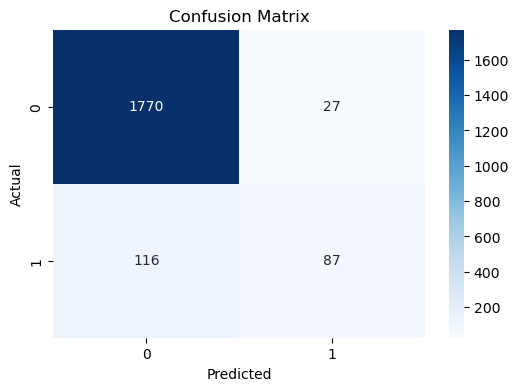

In [24]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [25]:
# Get coefficients from logistic regression model
coefficients = log_reg.coef_[0]

# Ensure we use scaled features for DataFrame
X_numeric_columns = X_numeric.columns  #only numeric features

# Create feature importance DataFrame
feature_importance = pd.DataFrame({
    'Feature': X_numeric_columns,
    'Coefficient': coefficients
})

# Sort DataFrame by coefficients
feature_importance.sort_values(by='Coefficient', ascending=False, inplace=True)
print(feature_importance)

                       Feature  Coefficient
3  Money Laundering Risk Score     2.368003
4     Shell Companies Involved     0.067652
2              Person Involved     0.011666
0                   Unnamed: 0     0.000359
5          Transaction_Seconds     0.000359
1                 Amount (USD)    -0.041511


In [26]:
# Perform cross-validation
cv_scores = cross_val_score(log_reg, X_train_scaled, y_train, cv=5, scoring='f1')
print(f'Cross-Validation F1 Scores: {cv_scores}')
print(f'Mean F1 Score: {cv_scores.mean():.4f}')

Cross-Validation F1 Scores: [0.60363636 0.5530303  0.58498024 0.60076046 0.62043796]
Mean F1 Score: 0.5926


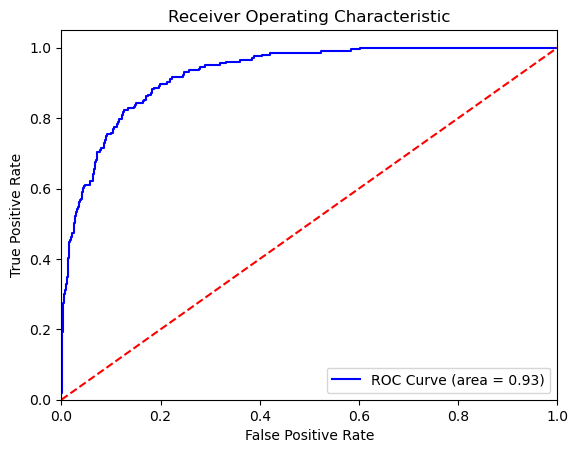

In [27]:
# Get predicted probabilities
y_scores = log_reg.predict_proba(X_test_scaled)[:, 1]  # Probability of the positive class

# Compute ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_scores)
roc_auc = auc(fpr, tpr)

# Plot ROC Curve
plt.figure()
plt.plot(fpr, tpr, color='blue', label='ROC Curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

### Model 2: Random Forest Classifier

In [28]:
# Initialize the Random Forest model
rf_model = RandomForestClassifier(random_state=42)

# Fit model to scaled training data
rf_model.fit(X_train_scaled, y_train)

# Make predictions on test set
y_pred = rf_model.predict(X_test_scaled)

# Evaluate model
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

print('Model Performance on Test Set:')
print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')

Model Performance on Test Set:
Accuracy: 0.9210
Precision: 0.9109
Recall: 0.9210
F1 Score: 0.9122


In [29]:
# Define hyperparameter grid to search
param_grid = {
    'n_estimators': [50, 100, 200],  # Number of trees in the forest
    'max_depth': [None, 10, 20, 30],  # Maximum depth of the tree
    'min_samples_split': [2, 5, 10],  # Minimum number of samples required to split an internal node
    'min_samples_leaf': [1, 2, 4]      # Minimum number of samples required to be at a leaf node
}

# Initialize Grid Search with cross-validation
grid_search = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=5, scoring='f1', n_jobs=-1)

# Fit Grid Search to training data
grid_search.fit(X_train_scaled, y_train)

# Best hyperparameters
print('Best hyperparameters:', grid_search.best_params_)

Best hyperparameters: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 50}


In [30]:
# Re-train model with best parameters
best_rf_model = grid_search.best_estimator_
best_rf_model.fit(X_train_scaled, y_train)

# Make predictions with tuned model
y_pred_tuned = best_rf_model.predict(X_test_scaled)

# Evaluate tuned model
accuracy_tuned = accuracy_score(y_test, y_pred_tuned)
precision_tuned = precision_score(y_test, y_pred_tuned, average='weighted')
recall_tuned = recall_score(y_test, y_pred_tuned, average='weighted')
f1_tuned = f1_score(y_test, y_pred_tuned, average='weighted')

print('Tuned Model Performance on Test Set:')
print(f'Accuracy: {accuracy_tuned:.4f}')
print(f'Precision: {precision_tuned:.4f}')
print(f'Recall: {recall_tuned:.4f}')
print(f'F1 Score: {f1_tuned:.4f}')

Tuned Model Performance on Test Set:
Accuracy: 0.9255
Precision: 0.9166
Recall: 0.9255
F1 Score: 0.9159


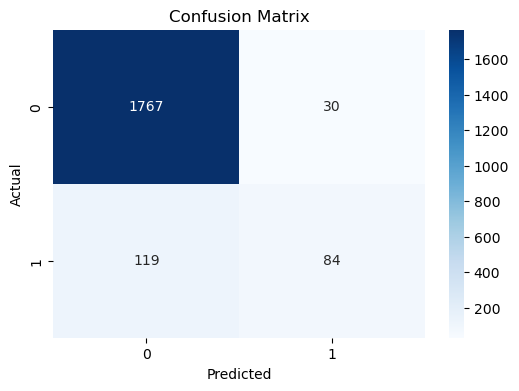

In [31]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_tuned)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [42]:
# Get feature importances from the Random Forest model
importance = best_rf_model.feature_importances_

X_numeric_columns = X_numeric.columns  # Numeric features from your dataset

# Create feature importance DataFrame based on Random Forest feature importances
feature_importance = pd.DataFrame({
    'Feature': X_numeric_columns,
    'Importance': importance
})

# Sort DataFrame by feature importance
feature_importance.sort_values(by='Importance', ascending=False, inplace=True)

print(feature_importance)

                       Feature  Importance
3  Money Laundering Risk Score    0.749232
2              Person Involved    0.060874
1                 Amount (USD)    0.057744
5          Transaction_Seconds    0.056149
0                   Unnamed: 0    0.053153
4     Shell Companies Involved    0.022848


In [43]:
# Perform cross-validation
cv_scores = cross_val_score(best_rf_model, X_train_scaled, y_train, cv=5, scoring='f1')
print(f'Cross-Validation F1 Scores: {cv_scores}')
print(f'Mean F1 Score: {cv_scores.mean():.4f}')

# Get predicted probabilities
y_scores = best_rf_model.predict_proba(X_test_scaled)[:, 1]  # Probability of the positive class

Cross-Validation F1 Scores: [0.6007326  0.53932584 0.57875458 0.60740741 0.61313869]
Mean F1 Score: 0.5879


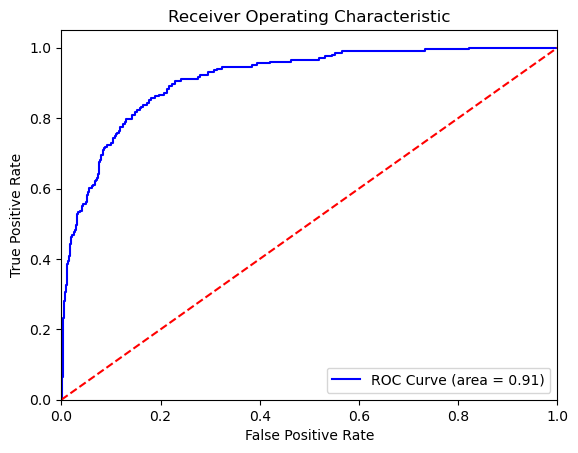

In [44]:
# Compute ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_scores)
roc_auc = auc(fpr, tpr)

# Plot ROC Curve
plt.figure()
plt.plot(fpr, tpr, color='blue', label='ROC Curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

### Model 3: LightGBM

## Conclusions